# Application Classification Report on lendingclub data
## Machine Learning Engineer Nanodegree li wang
2018-04-28

## 1.BackGround

With the development of Peer-to-peer credit industry in recent years, more and more consumers choose to solve the problem of temporary funds shortage  through Peer-to-peer loan. Unfortunately, although this is conducive to the allocation of funds, but the loan applicants for various reasons overdue by the phenomenon of many times, this gives Peer-to- peer company a certain degree of loss of bad debts.

In this project, the goal is to use the applicant's basic information, credit card transactions information and other data to build a machine learning model to identify users. The data used is the internationally renowned Peer-to-peer credit platform LendingClub official website opened in the third quarter of 2017 borrower data, involving 420,000 applicant samples, 145 feature information.

Data source:https://www.lendingclub.com/info/download-data.action

In [1]:
# import api
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mode
from scipy.interpolate import lagrange
from sklearn.model_selection import ShuffleSplit,StratifiedKFold

import scorecard_functions_V3 as sf
import feature_bin as fb
import datetime
from sklearn.preprocessing import Imputer
from sklearn.model_selection import train_test_split
import pickle
import preprocessing as pc
import missingno as msno
import seaborn as sns
import visualization as vs
import itertools
import helper as lp
import warnings
warnings.filterwarnings("ignore")

## 2.Data Information

This project is use the internationally renowned Peer-to-peer credit platform LendingClub official website opened in the third quarter of 2017 to analyze the borrower data, involving 420,000 applicant samples, 145 features information, including a good customer sample 350,199, and bad Customer sample 66175.It belongs to the sample distribution imbalanced data.

According to the Basel Agreement, the repayment status will stabilize after 12 months of repayment, and the loan term of the customer data used in the development model of the project is 36 or 60, and the repayment period is much more than 12 months,so the applicant repayment status is stable.

In [2]:
#data summary
data = pc.read_data('LoanStats3d.csv')

The data is the third quarter of 2017 borrower data of LendingClub opened on official website


top 5 line of data is :
     id  member_id  loan_amnt  funded_amnt  funded_amnt_inv        term  \
0  NaN        NaN     8800.0       8800.0           8800.0   36 months   
5  NaN        NaN     6000.0       6000.0           6000.0   36 months   

  int_rate  installment grade sub_grade       ...        \
0    9.80%       283.13     B        B3       ...         
5    7.91%       187.77     A        A5       ...         

  hardship_payoff_balance_amount hardship_last_payment_amount  \
0                            NaN                          NaN   
5                            NaN                          NaN   

  disbursement_method  debt_settlement_flag debt_settlement_flag_date  \
0                Cash                     N                       NaN   
5                Cash                     N                       NaN   

  settlement_status settlement_date settlement_amount  settlem

### separate training set and testing set
In this project i will only use data with 36 term,and i will use the apply date between Jan-2015 to Oct-2015 as my training set,the apply date is Nov-2015~Dec-2015 as my test data testing my model.

In [3]:
trainData,testData = pc.split_train_test(data)

the train data shape is: (227565, 145)
the test data shape is: (55608, 145)


## 3.Data Preprocessing

### 3.1 choose features and samples
The statistical analysis and the data show that the data sets are missing seriously, and some of the features are all missing,part of the discrete feature dtypes is been marked as float type, and there are some after loan features here, so the following work is cleansing no use columns,here is my strategy:
- remove the afterloan columns
- every feature must have at least two different values
- remove features that are missing more than 60% 
- every row or columns must have at least one value
- remove features that whose single value counts have 90 percent in all value
- remove specific columns whoes values greater than top 10

In [4]:
df = pc.drop_afterloan_columns(trainData)
df = pc.drop_unique1_col(df)
df = pc.drop_missingmore60_col(df)
df = pc.drop_row_col_miss(df)
df = pc.drop_90samevalue_col(df)

print('=====')
df = pc.get_label(df,'loan_status')
df = pc.string_to_value(df)
print('now,print top 5 row data:')
df.head()

after drop after loan data, the data shape is  (227565, 129)
after drop only one value columns, the data shape is  (227565, 95)
after drop missing greater than 60% columns, the data shape is  (227565, 69)
after delete 90% values same in one column,the data shape is (227565, 59)
=====
now,print top 5 row data:


,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,...,num_sats,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,y
78943,4000.0,4000.0,4000.0,0.1699,142.60,4,43,driver,6.0,RENT,...,5.0,3.0,93.3,100.0,0.0,39106.0,34227.0,2300.0,34906.0,0
78947,10000.0,10000.0,10000.0,0.1433,343.39,3,35,Network Administrator,8.0,MORTGAGE,...,8.0,3.0,91.7,0.0,0.0,234244.0,40585.0,15900.0,32107.0,0
78949,4800.0,4800.0,4800.0,0.0789,150.18,1,15,Office Manager/Sonographer/Phlebotomist,2.0,OWN,...,12.0,0.0,86.2,50.0,0.0,43875.0,32607.0,6000.0,27675.0,0
78954,3000.0,3000.0,3000.0,0.0624,91.60,1,12,nuclear medicine technologist,10.0,MORTGAGE,...,12.0,3.0,96.6,0.0,0.0,197463.0,28184.0,22900.0,38818.0,0
78959,6000.0,6000.0,6000.0,0.0624,183.19,1,12,Family Services Supervisor,10.0,RENT,...,4.0,0.0,100.0,0.0,0.0,50816.0,26778.0,18000.0,26316.0,0


### 3.2 outlier preprocessing
In this project, i have found outlier is a very normal problem,so i choose to delete top ten value samples for each columns and then,i will use data box strategy to eliminate the effect of outliers.

In [5]:
word_col,cat_col,ordered_col,continue_col = pc.get_word_cat_ordered_continue_col(df)
orded_col_outlier=[w for w in ordered_col if w not in ['grade','sub_grade','earliest_cr_line','int_rate',
                                                       'inq_last_6mths',
                                                       'emp_length','dti','percent_bc_gt_75','pub_rec_bankruptcies']]

all_outlier = orded_col_outlier + continue_col
all_outlier_index=[]
for key in all_outlier:
    temp = pc.del_outlier_index(df,key)
    all_outlier_index.append(temp)
outlier_index = list(set(list(itertools.chain(*all_outlier_index))))#get outlier_index
df = df.drop(outlier_index,axis=0) # no outlier
print('after delete outliers,the data shape now is:',df.shape)

after delete outliers,the data shape now is: (222662, 59)


In [6]:
# save result
f = open('df.pkl','wb')
pickle.dump(df,f)

In [7]:
#load result
with open('df.pkl', 'rb') as f:
    df = pickle.load(f)

### 3.2 feature visualization

**Data Explot summary**
- label: from label columns 'y' distribution,i find in this project it belongs to two classes imbalanced sample classification problems
- cat_col: we can see from the following graph,most of the borroweres have house but in mortgage station and people who rent aparterment have much higher overdue rate than others;the main purpose of apply loan is debt_consolidation.
- word_cloud: tearcher is the more job for borrower filling and plenty of people didn't fill this information;'945XX'and '750XX' is the most zip_code for borrower filling and the 'TX' and 'CA' for 'addr_state'.
- youxu_col:in this part,i find most borroweres's FISO score in grade C to grade E,and most people have work at least ten years.many feature have serious outlier.
- lianxu_col: some feature have beatiful normal distribution but some not,like youxu_col,some features have serious outlier.

#### 1.Distribution histogram of target y
It can be seen from the histogram that the number of overdue users is about 14%, 
it means this project belongs to imbalanced sample classification.

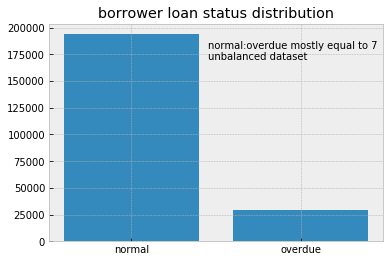

In [10]:
vs.plot_label(df,'y')

#### 2. catergory feature histogram on normal and overdue

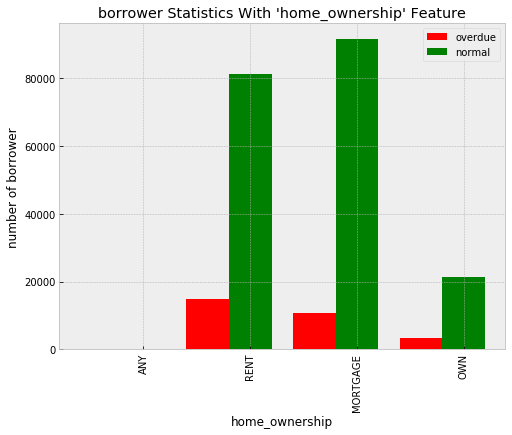

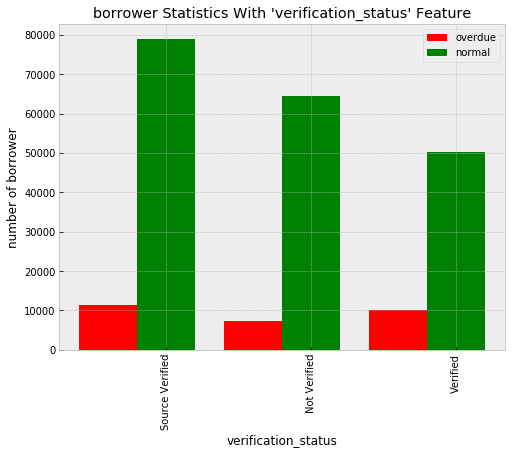

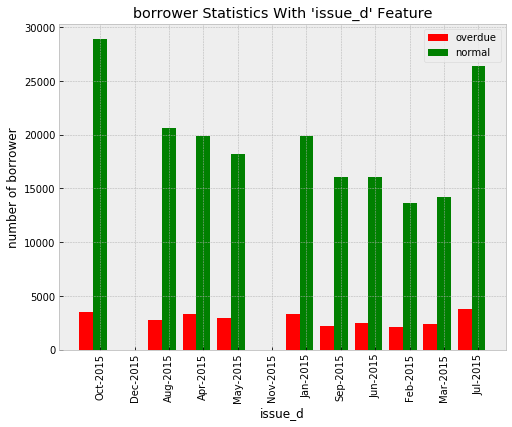

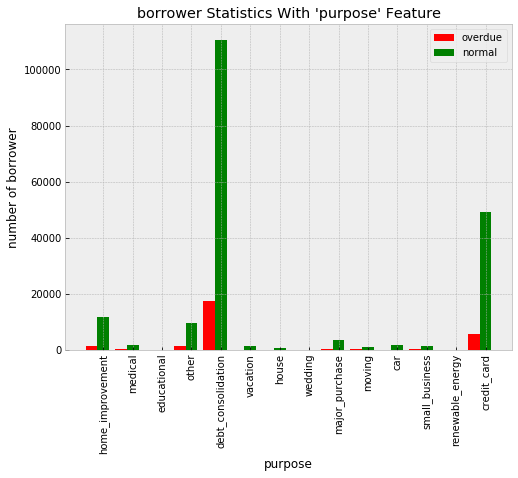

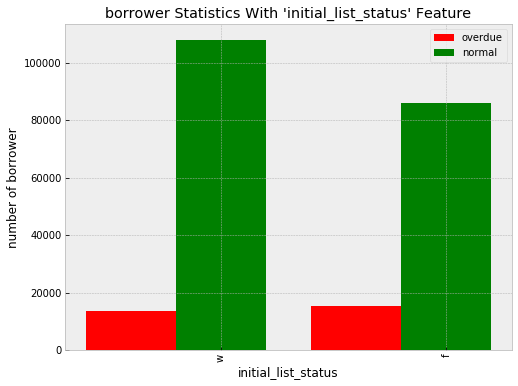

In [11]:
word_col,cat_col,ordered_col,continue_col = pc.get_word_cat_ordered_continue_col(df)
for key in [w for w in cat_col]:
    vs.plot_cat(df,key)

#### 3.text feature word cloud

emp_title word cloud:
borrower with missing 'emp_title' values: 14525 (2751 overdue, 11774 normal)


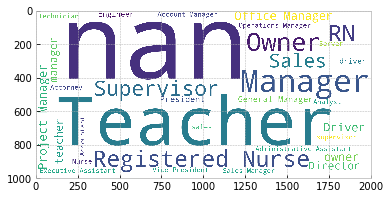

In [12]:
print('emp_title word cloud:')
vs.word_cloud(df,'emp_title')

zip_code word cloud:


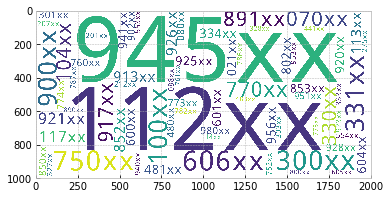

In [13]:
print('zip_code word cloud:')
vs.word_cloud(df,'zip_code')

addr_state word cloud:


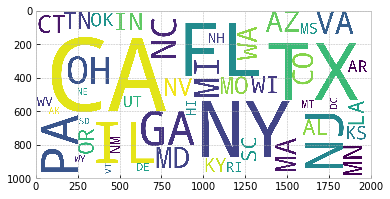

In [14]:
print('addr_state word cloud:')
vs.word_cloud(df,'addr_state')

#### 4. ordinal feature distribution

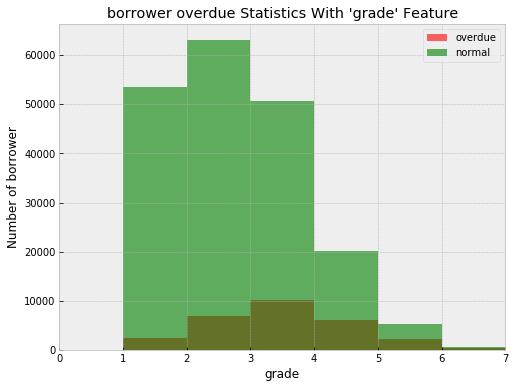

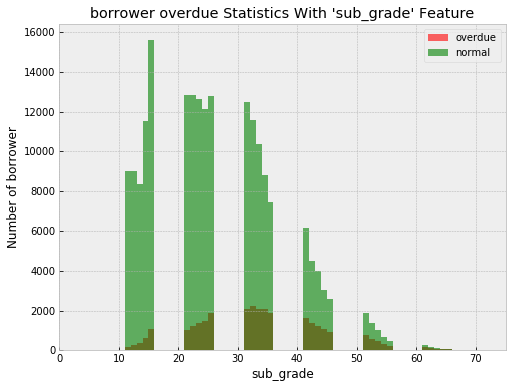

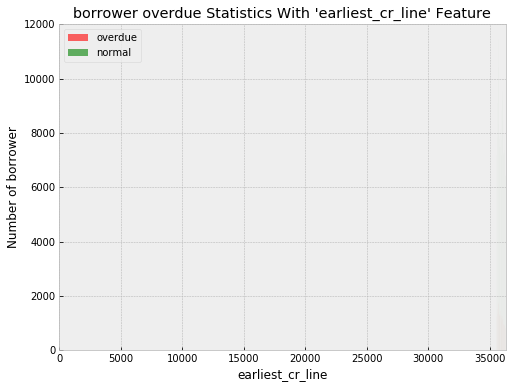

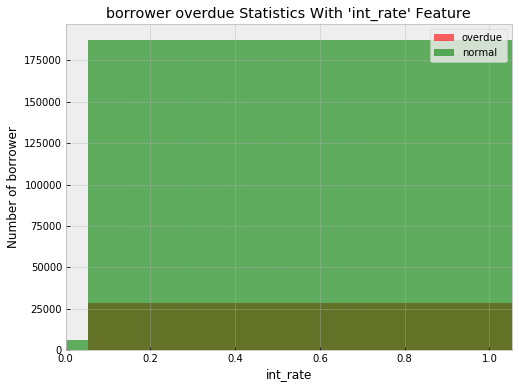

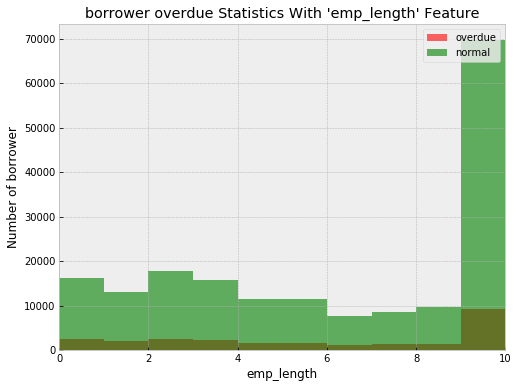

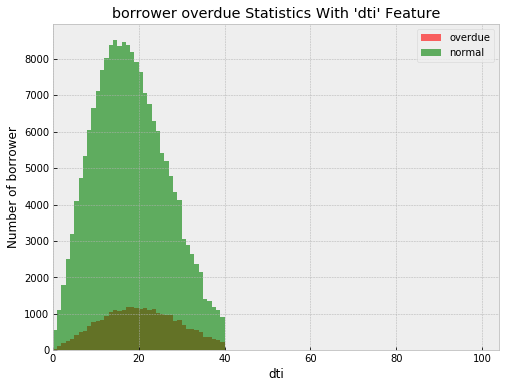

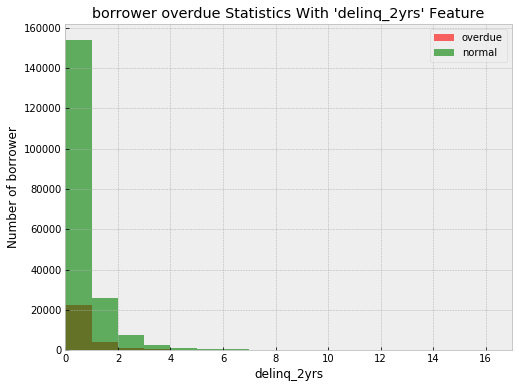

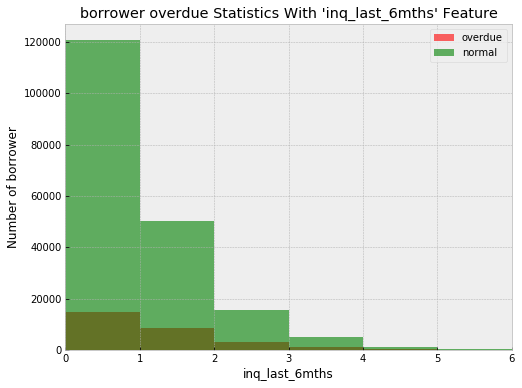

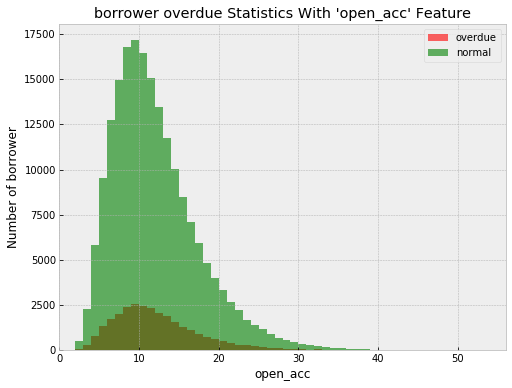

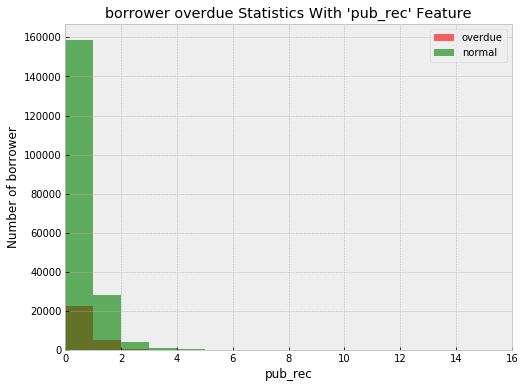

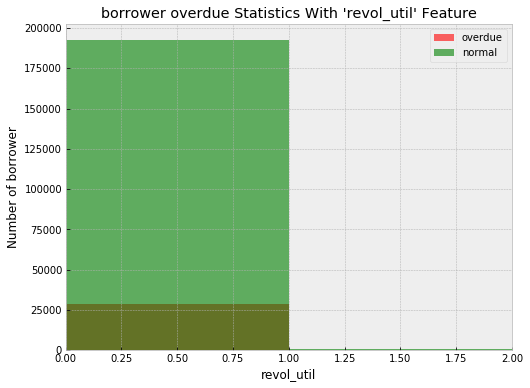

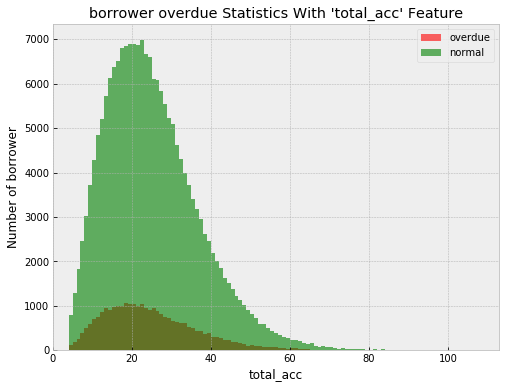

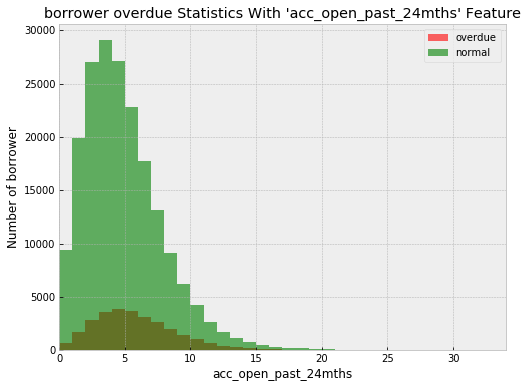

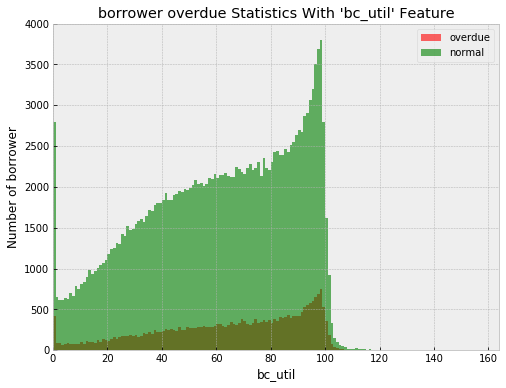

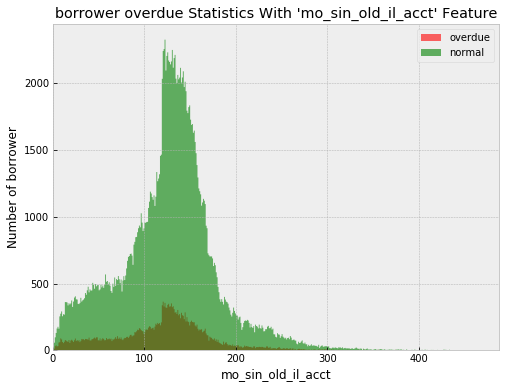

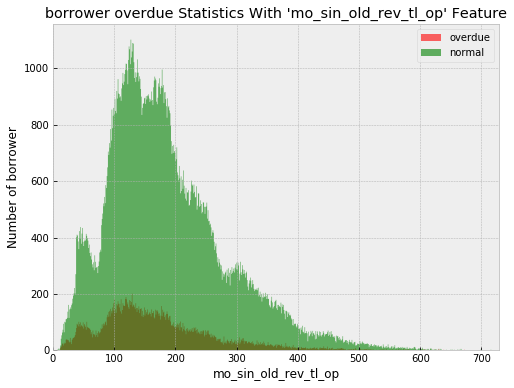

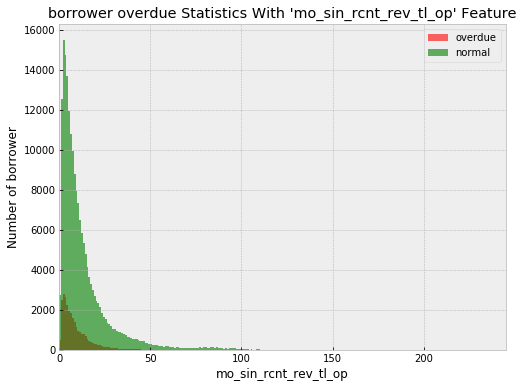

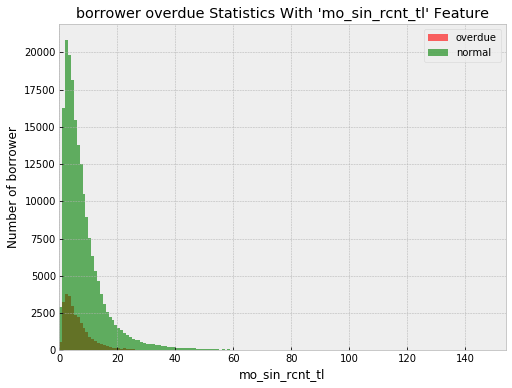

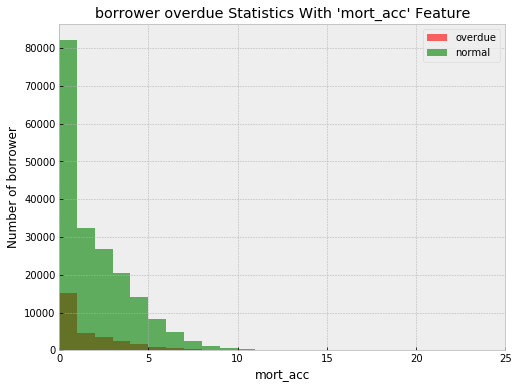

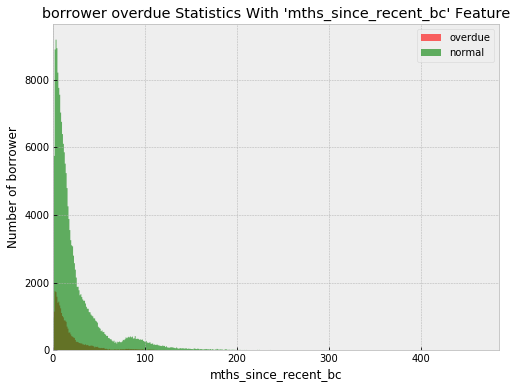

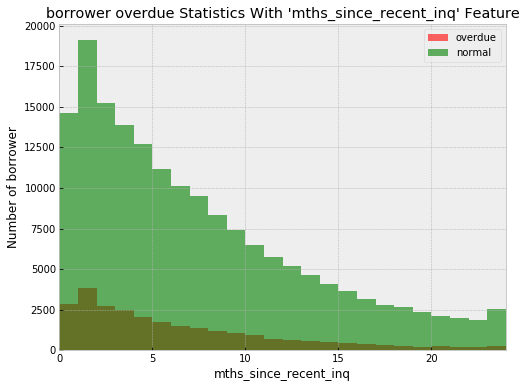

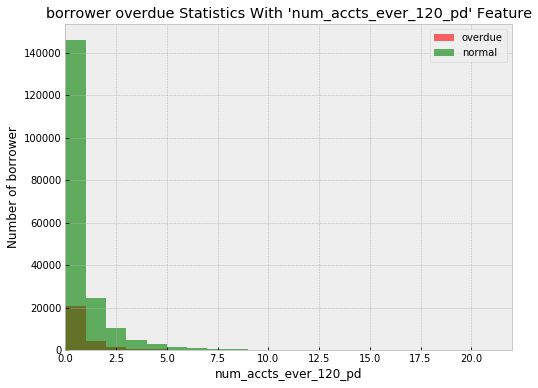

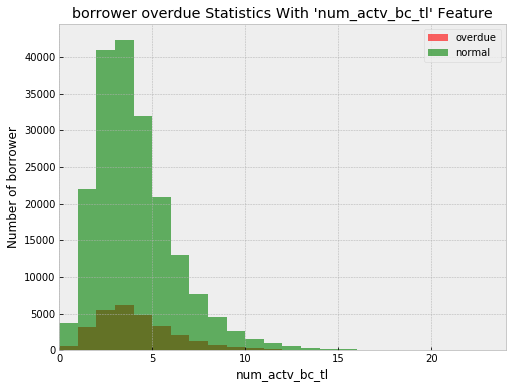

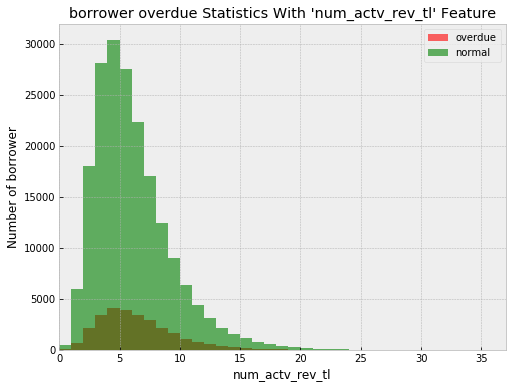

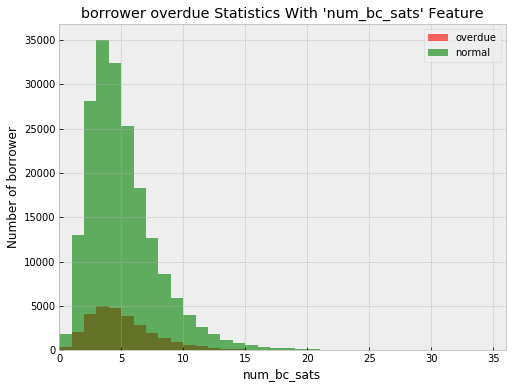

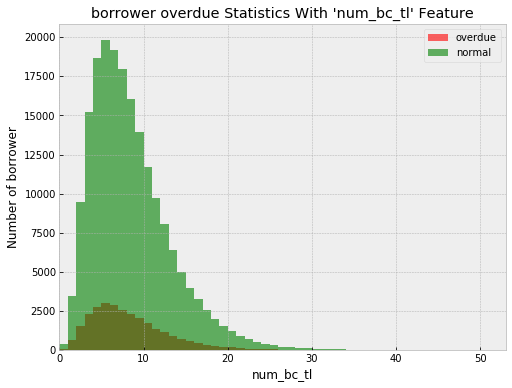

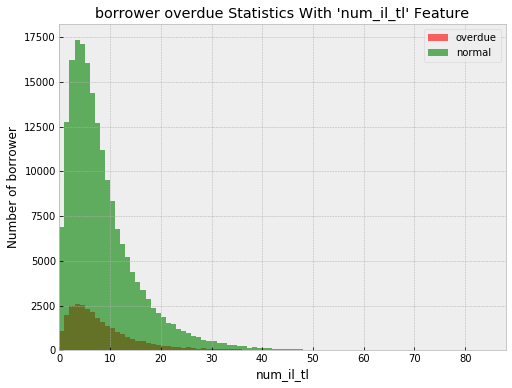

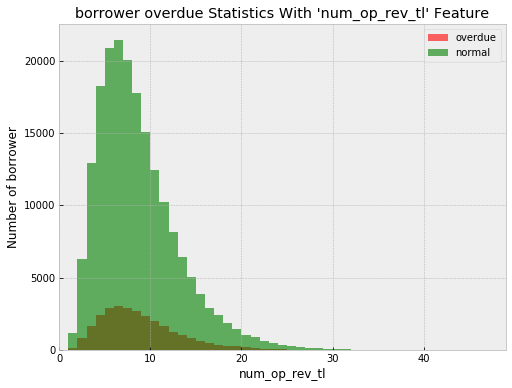

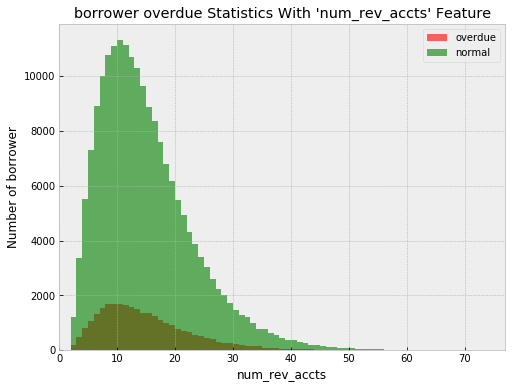

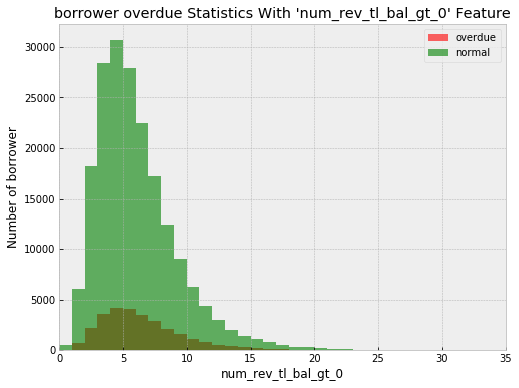

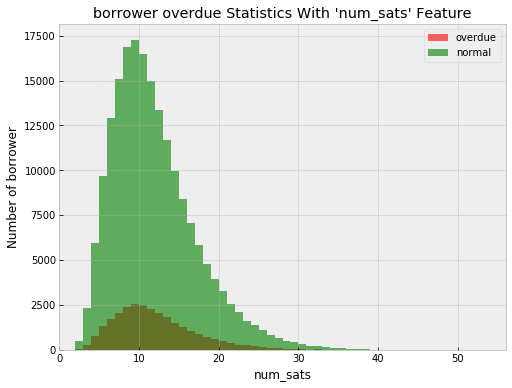

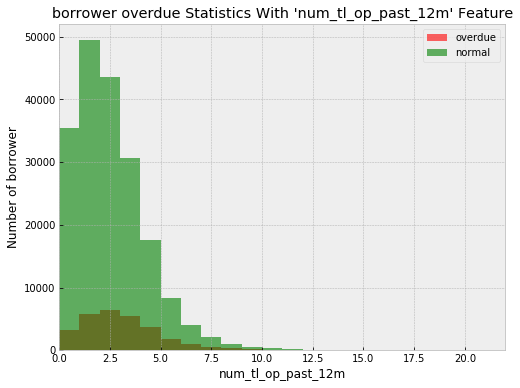

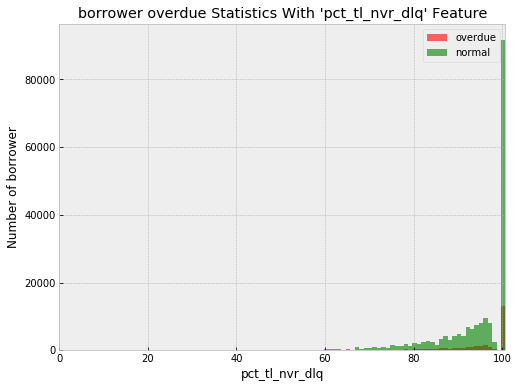

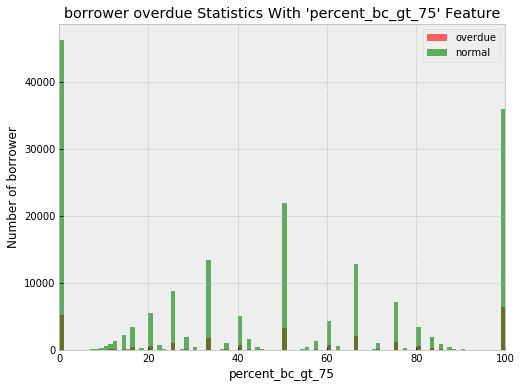

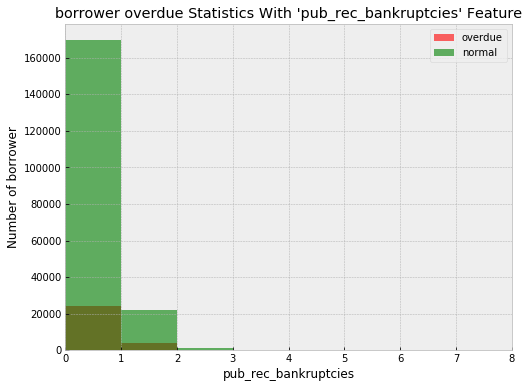

In [15]:
for key in ordered_col:
    vs.plot_youxu_col(df,'y',key)

#### 5.lianxu feature distribution

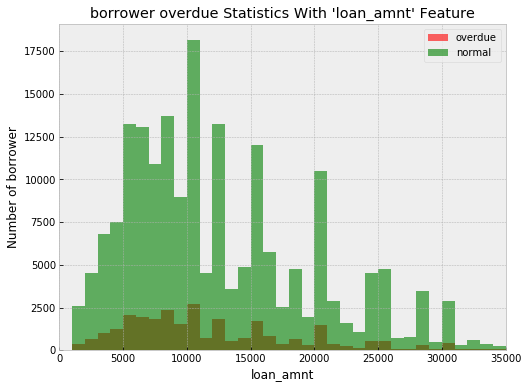

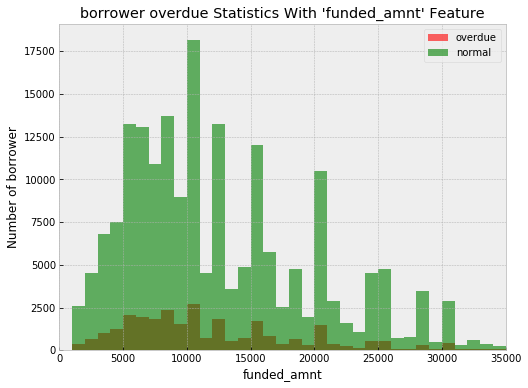

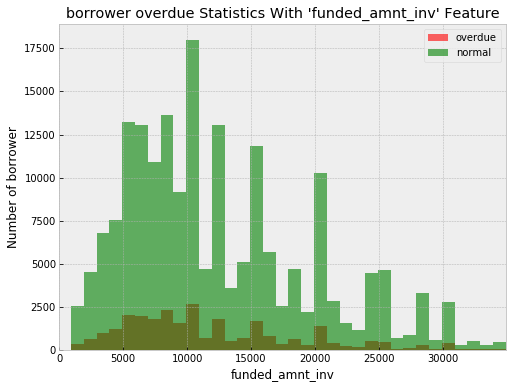

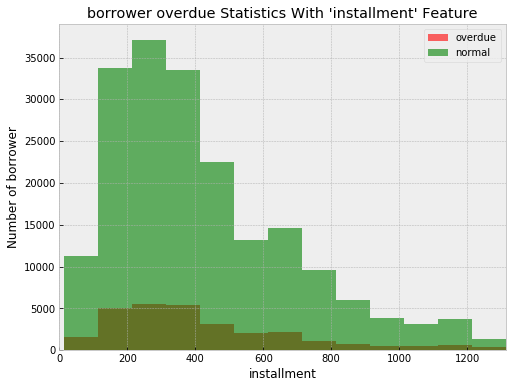

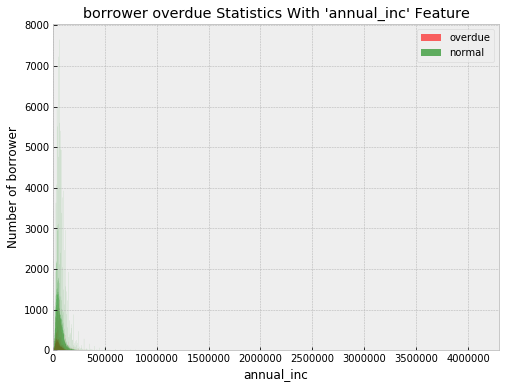

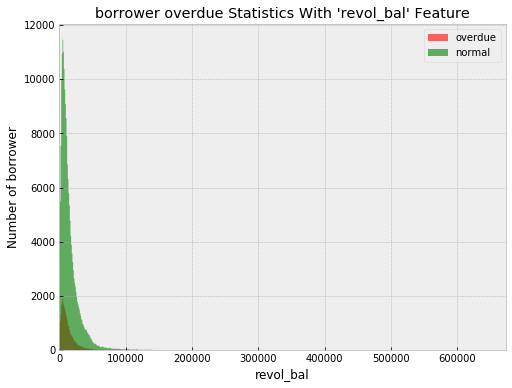

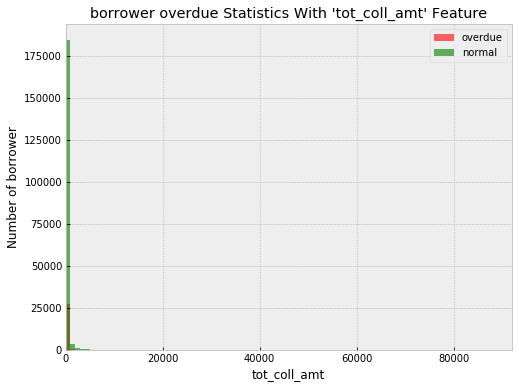

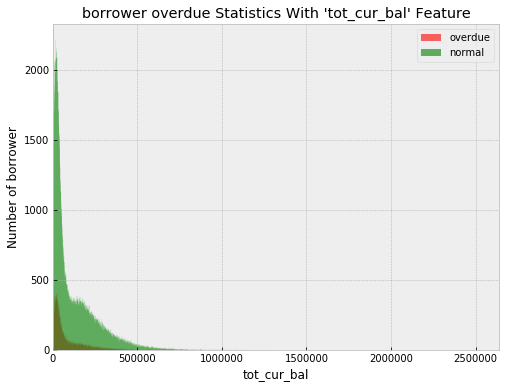

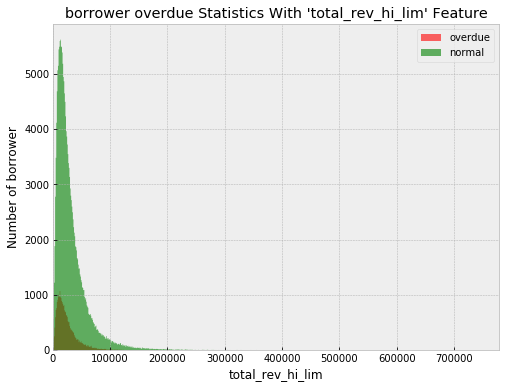

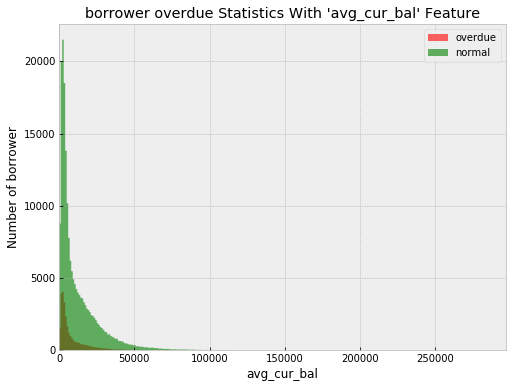

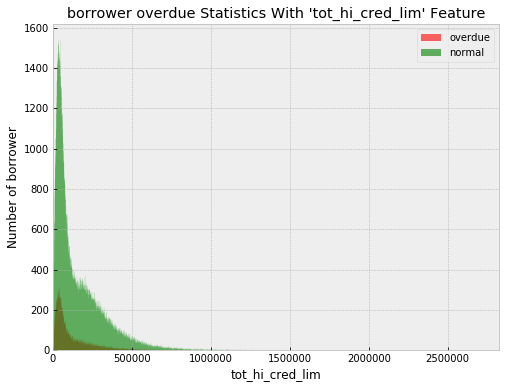

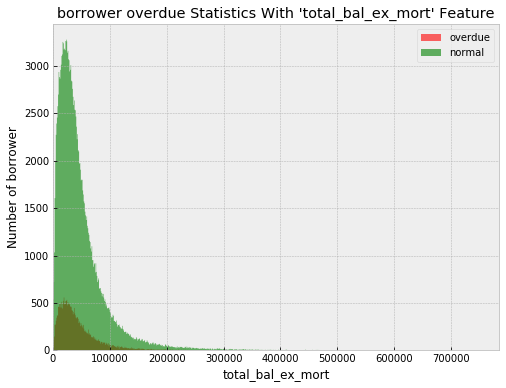

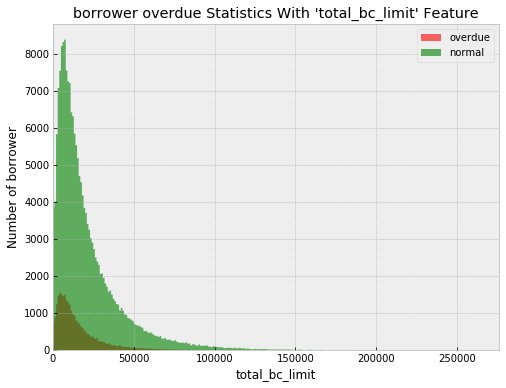

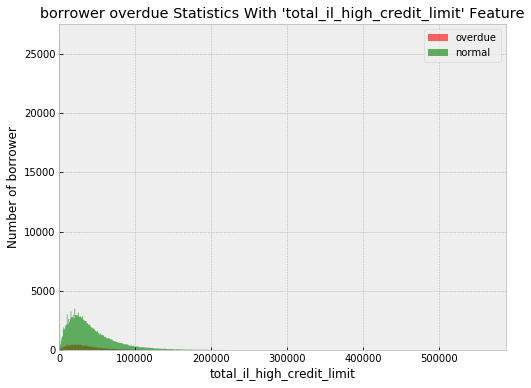

In [16]:
continue_col=[key for key in continue_col if key!='bc_open_to_buy']
for key in continue_col:
    vs.plot_lianxu_col(df,'y',key)

**According to the data visulization, we find some feature have seriously null and outlier,so we deal with it with the following strategy.**

### 3.3 missing processing
here is my strategy:
- Continuous features use mean filling
- Classification feature use the mode filling

missing matrix graph:


columns having missingvalues ['emp_title', 'emp_length', 'bc_open_to_buy', 'bc_util', 'mo_sin_old_il_acct', 'mths_since_recent_bc', 'mths_since_recent_inq', 'num_rev_accts', 'percent_bc_gt_75']


bingo,no missing!


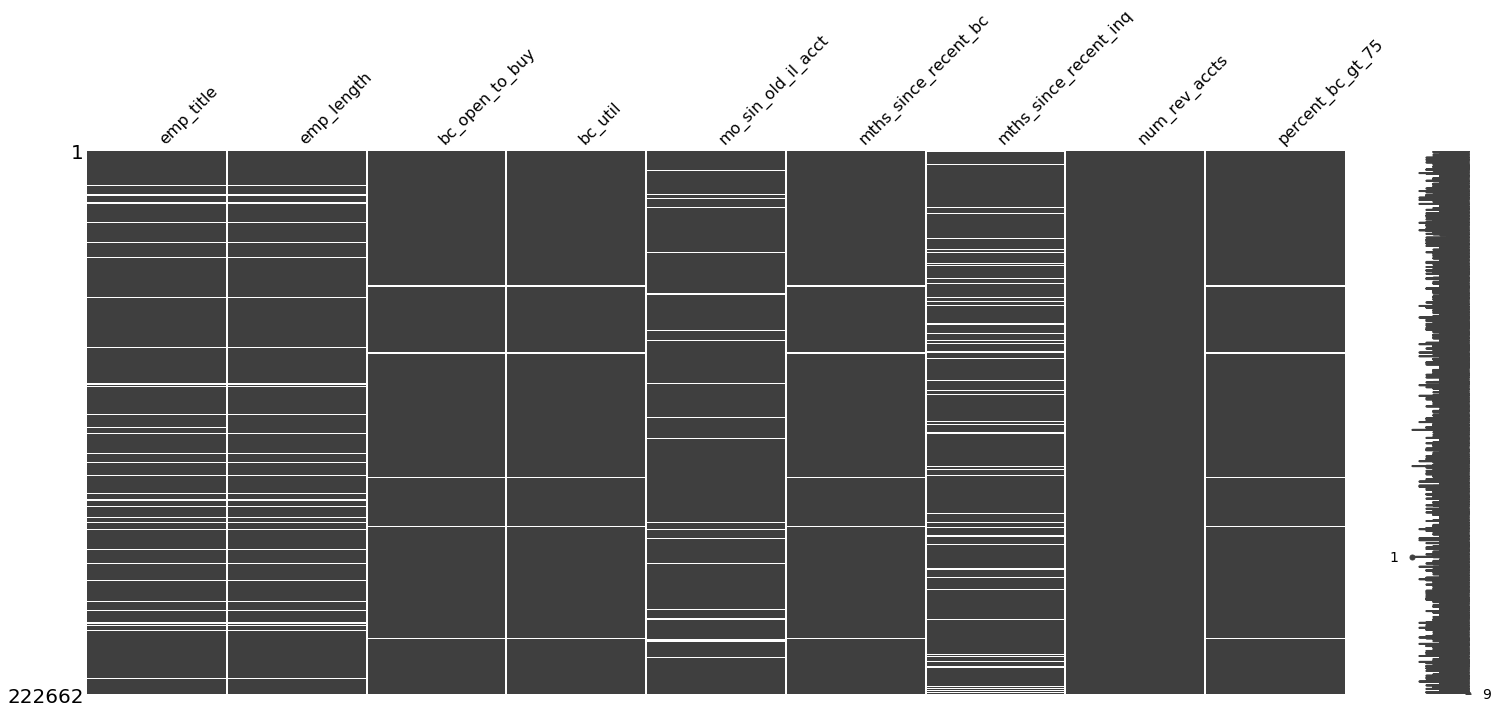

In [17]:
# missing values counts
%matplotlib inline
missing_col=list(df.isnull().sum()[df.isnull().sum()>0].index)
print('missing matrix graph:')
msno.matrix(df[missing_col])
print('\n')
print('columns having missingvalues',missing_col)
print('\n')

#filling missing
df = pc.missing_fill(df)
df.isnull().sum()[df.isnull().sum()>0]
print('bingo,no missing!')

### 3.4 outlier processing


here is my strategy:
- cat_col:'home_ownership' turn 'ANY' to 'MORTGAGE'
- value_col: first we delele top 10 values sample[have done],second, i will use Chi-square box strategy

In [19]:
df['home_ownership']=df['home_ownership'].apply(pc.any_to_mort)

** Now,the missing and outliers have been done,but we can see from the data view,they are still some string features there,so i will use bin-counting method coding these features.**

[reference:feature engineering for machine learning principle and techniques for data scientists]

### 3.5 Catergory Data Transpose

here is my strategy:
- if some catergory feature have less than 5(including 5) unique values,i will use dummy code method;
- if some catergory feature have more than 5 unique values, i will use bin-counting method

the idea of bin-counting is: rather than using value of the categorial variable as the feature,instead we use conditional probability of the target under that value.

In [20]:
#catorgery feature encoding
cols_set = [w for w in cat_col+word_col] # get columns need to be seperate
df_code = lp.get_more_cat_code(df,cols_set,'y') # badrate编码
df_code = df_code.drop(cols_set,axis=1)
print('now,data shape is :',df_code.shape)
df_code.head()

now,data shape is : (222662, 59)


,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,grade,sub_grade,emp_length,annual_inc,dti,...,total_il_high_credit_limit,y,home_ownership_Bin,verification_status_Bin,issue_d_Bin,purpose_Bin,initial_list_status_Bin,zip_code_Bin,addr_state_Bin,emp_title_Bin
78943,4000.0,4000.0,4000.0,0.1699,142.60,4,43,6.0,77000.0,11.35,...,34906.0,0,0.154615,0.166760,0.107823,0.138043,0.110899,0.103896,0.114657,0.228327
78947,10000.0,10000.0,10000.0,0.1433,343.39,3,35,8.0,60181.0,16.35,...,32107.0,0,0.104449,0.126694,0.107823,0.104178,0.152042,0.099174,0.097363,0.051020
78949,4800.0,4800.0,4800.0,0.0789,150.18,1,15,2.0,45000.0,9.28,...,27675.0,0,0.136640,0.126694,0.107823,0.104178,0.110899,0.144020,0.138979,0.000000
78954,3000.0,3000.0,3000.0,0.0624,91.60,1,12,10.0,75000.0,15.87,...,38818.0,0,0.104449,0.102030,0.107823,0.150233,0.110899,0.146018,0.141298,0.000000
78959,6000.0,6000.0,6000.0,0.0624,183.19,1,12,10.0,61000.0,10.35,...,26316.0,0,0.154615,0.102030,0.107823,0.138043,0.110899,0.154472,0.122766,0.000000


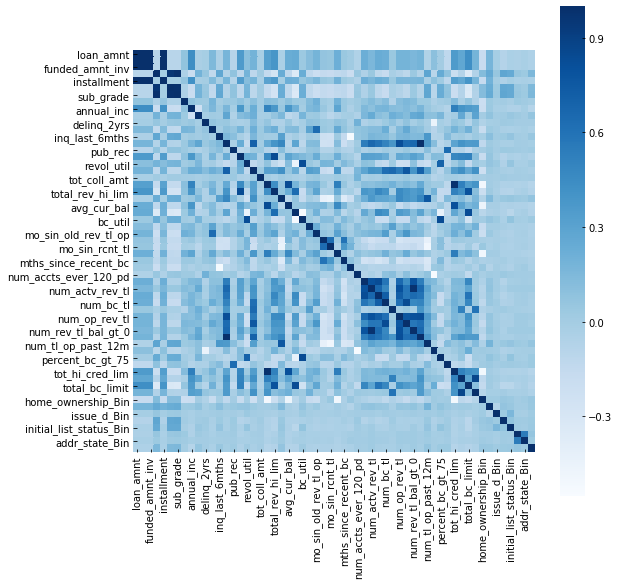

In [22]:
#get the correlation relationship beteen two columns
vs.plot_corrmatrix_heatmap(df_code.drop('y',axis=1))

Until now, the data preprocessing and exploration work have been finished. we have seen that there are 59 features in the dataset.some two features have strong correlation relationship,so we shold elimanate the relationship of features before we build a model.

In [23]:
# save result
f = open('df_code.pkl','wb')
pickle.dump(df_code,f)

In [2]:
#load result
with open('df_code.pkl', 'rb') as f:
    df_code = pickle.load(f)

### 5. Implement feature dealing strategy

Above show the data exploration process,it's huge and not easy to training model,so the following import word is feature selection.After researching many useful papers and some useful strategy in actual finance scene,feature bin is a very useful strategy for mining feature rules.So,i will use chimerge box dealing with the dataset.

Here is my strategy:
- step 1: calculating chi_merge box,because it has been proved the most effective strategy for feature bin box
- step 2: calculating IV values of features,remove the features with the IV values less than 0.01
- step 3: calculate VIF of features,delete who has big VIF and low IV value,until all feature VIF values less than 10
- step 4: test the relation between feature,make sure there are no two feature have strong relationship
- step 4: training randomforest algrimn,get top 10 important feature training base model.

In [3]:
# order feature encode and merge

ordered_col = ['grade','sub_grade','earliest_cr_line','int_rate',
 'emp_length','delinq_2yrs','inq_last_6mths','open_acc','pub_rec',
 'revol_util','total_acc','acc_open_past_24mths','bc_util','mo_sin_old_il_acct',
 'mo_sin_old_rev_tl_op','mo_sin_rcnt_rev_tl_op','mo_sin_rcnt_tl','mort_acc',
 'mths_since_recent_bc','mths_since_recent_inq','num_accts_ever_120_pd',
 'num_actv_bc_tl','num_actv_rev_tl','num_bc_sats','num_bc_tl','num_il_tl',
 'num_op_rev_tl','num_rev_accts','num_rev_tl_bal_gt_0','num_sats','num_tl_op_past_12m',
 'pct_tl_nvr_dlq','percent_bc_gt_75','pub_rec_bankruptcies','bc_open_to_buy']

#get order fetures merge bin
order_data = df_code[ordered_col]
order_data['y']=df_code['y']
df_order = lp.order_encode(order_data,ordered_col) # get merge bin

starting bad part=========
int_rate need to be combined due to 0 bad rate
open_acc need to be combined due to 0 bad rate
pub_rec need to be combined due to 0 bad rate
revol_util need to be combined due to 0 bad rate
total_acc need to be combined due to 0 bad rate
acc_open_past_24mths need to be combined due to 0 bad rate
bc_util need to be combined due to 0 bad rate
mo_sin_old_il_acct need to be combined due to 0 bad rate
mo_sin_old_rev_tl_op need to be combined due to 0 bad rate
mo_sin_rcnt_rev_tl_op need to be combined due to 0 bad rate
mo_sin_rcnt_tl need to be combined due to 0 bad rate
mort_acc need to be combined due to 0 bad rate
mths_since_recent_bc need to be combined due to 0 bad rate
num_accts_ever_120_pd need to be combined due to 0 bad rate
num_actv_bc_tl need to be combined due to 0 bad rate
num_actv_rev_tl need to be combined due to 0 bad rate
num_bc_sats need to be combined due to 0 bad rate
num_bc_tl need to be combined due to 0 bad rate
num_il_tl need to be combined d

In [4]:
# concat and bin
df = df_code.drop(ordered_col+['y'],axis=1)
all_data = pd.concat([df,df_order],axis=1)

# chimerge bin 
cols_set=[w for w in all_data if w !='y']
continues_merge_dict,var_bin_list,all_df = lp.get_cutoff(all_data,cols_set,'y')

loan_amnt is in processing
funded_amnt is in processing
funded_amnt_inv is in processing
installment is in processing
annual_inc is in processing
dti is in processing
revol_bal is in processing
tot_coll_amt is in processing
tot_cur_bal is in processing
total_rev_hi_lim is in processing
avg_cur_bal is in processing
tot_hi_cred_lim is in processing
total_bal_ex_mort is in processing
total_bc_limit is in processing
total_il_high_credit_limit is in processing
issue_d_Bin is in processing
purpose_Bin is in processing
zip_code_Bin is in processing
addr_state_Bin is in processing
emp_title_Bin is in processing
grade_Bin is in processing
sub_grade_Bin is in processing
earliest_cr_line_Bin is in processing
emp_length_Bin is in processing
delinq_2yrs_Bin is in processing
inq_last_6mths_Bin is in processing
mths_since_recent_inq_Bin is in processing
pub_rec_bankruptcies_Bin is in processing
int_rate_Merge_Bin is in processing
open_acc_Merge_Bin is in processing
pub_rec_Merge_Bin is in processing


In [19]:
# save result
f = open('all_df.pkl','wb')
pickle.dump(all_df,f)

f1 = open('cols_set.pkl','wb')
pickle.dump(cols_set,f1)


f2 = open('var_bin_list.pkl','wb')
pickle.dump(var_bin_list,f2)

In [3]:
#load result
with open('all_df.pkl', 'rb') as f:
    all_df = pickle.load(f) 

with open('cols_set.pkl','rb') as f1:
    cols_set = pickle.load(f1)

with open('var_bin_list.pkl','rb') as f2:
    var_bin_list = pickle.load(f2)

In [7]:
# calculate woe values and iv values
less_cols,more_cols = lp.get_less_more_cat_col(all_df,cols_set)
all_columns = less_cols + var_bin_list
col_IV,IV_WOE = lp.get_woe_iv(all_df,all_columns,'y')

# choose top 10 iv value features
high_IV = {k:v for k, v in col_IV.items() if v >= 0.01}
high_IV_sorted = sorted(high_IV.items(),key=lambda x:x[1],reverse=True)
IV_top10_col = list(dict(high_IV_sorted[0:10]).keys())
for var in IV_top10_col:
    newVar = var+'_WOE'
    all_df[newVar] = all_df[var].map(IV_WOE[var])
base_model_data = all_df[[w+'_WOE' for w in IV_top10_col]] #iv top 10 features
use_feature =[w.replace('_Bin','') for w in IV_top10_col]
use_feature =[w.replace('_Bin','') for w in use_feature]
print('the features used in base model is:',use_feature)

the features used in base model is: ['bc_open_to_buy_Merge', 'emp_title', 'int_rate_Merge', 'sub_grade', 'grade', 'acc_open_past_24mths_Merge', 'num_tl_op_past_12m_Merge', 'total_bc_limit', 'tot_hi_cred_lim', 'avg_cur_bal']


In [23]:
# save result
f = open('col_IV.pkl','wb')
pickle.dump(col_IV,f)

f1 = open('IV_WOE.pkl','wb')
pickle.dump(IV_WOE,f1)

f2 = open('base_model_data.pkl','wb')
pickle.dump(base_model_data,f2)

In [4]:
#load result
with open('col_IV.pkl', 'rb') as f:
    col_IV = pickle.load(f) 

with open('IV_WOE.pkl','rb') as f1:
    IV_WOE = pickle.load(f1)

with open('base_model_data.pkl','rb') as f2:
    base_model_data = pickle.load(f2)

Now,i will plot two features correlation heatmap again,and get the feature woe and iv values,choose top 10 iv value feature as my base model features

### Basic Model

i will use top 10 iv value feature to train randomforest model as my base model

the 5 folds cross validation roc curve is:


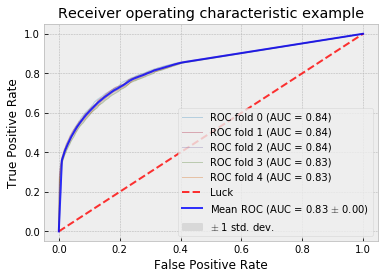



the ks value of base model is : 0.7557107520425962


In [5]:
# basic model 
from sklearn.ensemble import RandomForestClassifier

# get array format data feature:X,label:y
X = np.array(base_model_data)
y = np.array(df_code['y'])

clf=RandomForestClassifier()
clf.fit(X,y)
pred = clf.predict_proba(X)[:,1]
df = pd.DataFrame([pred,y]).T
df.columns = ['score','y']
print('the 5 folds cross validation roc curve is:')
clf = RandomForestClassifier()
vs.model_roc_curve(X,y,clf)

print('\n')
print('the ks value of base model is :',lp.KS(df,'score','y'))

### Optimization
- elimanate correlation:my strategy is if two feature have strong relationship,i will drop the low iv value one
- build model:this part i will use LR model and randomforest to training
- grid research:set some range of parameter using grid research stratey to search the best model parameter.

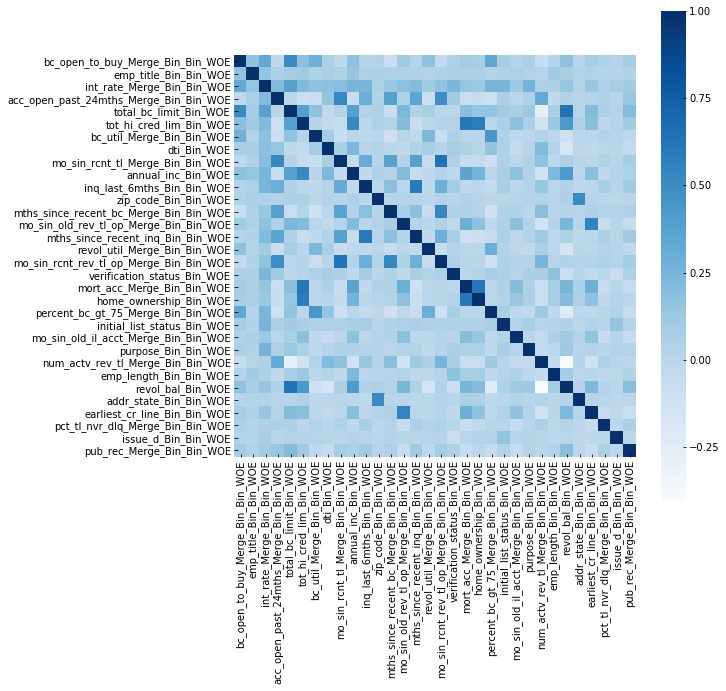

In [9]:
# get features with iv more than 0.01
short_list_2 = lp.choose_iv_feature(all_df,col_IV,IV_WOE) 
# calculate two feature correlation coefficent
multi_analysis_vars_1 = lp.cor_feature(all_df,col_IV) 
# plot been chosen features corrmatrix heatmap 
vs.plot_corrmatrix_heatmap(all_df[multi_analysis_vars_1]) 

In [25]:
# save result
f = open('multi_analysis_vars_1.pkl','wb')
pickle.dump(multi_analysis_vars_1,f)

In [6]:
#load result
with open('multi_analysis_vars_1.pkl', 'rb') as f:
    multi_analysis_vars_1= pickle.load(f) 

In [10]:
# calculate vif
from statsmodels.stats.outliers_influence import variance_inflation_factor
X = np.matrix(all_df[multi_analysis_vars_1])
VIF_list = [variance_inflation_factor(X, i) for i in range(X.shape[1])]
max_VIF = max(VIF_list)
print ('the max vif is :',max_VIF)

the max vif is : 2.72370423322213


logistic regression result is
the roc curve is:


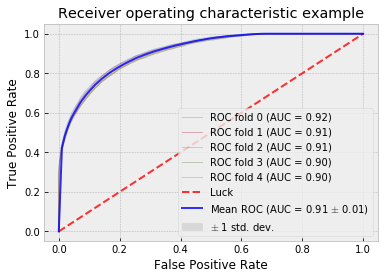

the ks value is : 0.6359971446604776
randomforest regression result is
the roc curve is:


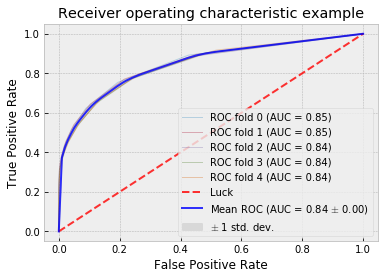

the ks value is : 0.990604595747427


In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
X = np.array(all_df[multi_analysis_vars_1])
print('logistic regression result is')
clf_lr = LogisticRegression()
lp.lr_train(X,y,clf_lr)
print('randomforest regression result is')
clf_rf = RandomForestClassifier()
lp.lr_train(X,y,clf_rf)

In [13]:
def grid_research(X,y,clf,paremeter):
    from sklearn.model_selection import GridSearchCV
    cv = StratifiedKFold(n_splits=5)
    grid = GridSearchCV(clf,paremeter,cv=cv)
    grid.fit(X,y)
    return grid.best_params_

In [15]:
# logistic regression grid research
print('the logistic grid research result is:')
clf_lr = LogisticRegression()
paramer_lr= {'penalty':('l1','l2'),
              'C':(0.001,0.01,0.1,1,10,100,1000),
               'class_weight':({0:1,1:4},{0:1,1:1})}
lr_best_paramters = grid_research(X,y,clf_lr,paramer_lr)

the logistic grid research result is:


In [17]:
print('the best paramters for logistic regression is',lr_cv_results)

the best paramters for logistic regression is {'C': 0.01, 'class_weight': {0: 1, 1: 1}, 'penalty': 'l2'}


In [18]:
# logistic regression grid research
from sklearn.model_selection import ShuffleSplit,StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
print('the randomforest grid research result is:')
clf_rf = RandomForestClassifier()
paramer_rf ={'n_estimators':(5,10,20),
          'criterion':('entropy','gini'),
          'max_depth':(4,6),
           'class_weight':({0:1,1:4},{0:1,1:1})}
rf_best_params = grid_research(X,y,clf_rf,paramer_rf)
print('the best paramters for randomforest is ',rf_best_params)

the randomforest grid research result is:
the best paramters for randomforest is  {'class_weight': {0: 1, 1: 1}, 'criterion': 'gini', 'max_depth': 6, 'n_estimators': 20}


In [19]:
#final parameter
print('========================')
print('the best paramters for logistic regression is',lr_cv_results)
print('========================')
print('the randomforest best paramters is:',rf_best_params)

the best paramters for logistic regression is {'C': 0.01, 'class_weight': {0: 1, 1: 1}, 'penalty': 'l2'}
the randomforest best paramters is: {'class_weight': {0: 1, 1: 1}, 'criterion': 'gini', 'max_depth': 6, 'n_estimators': 20}


#### 5.6 evaluation

the roc curve is:


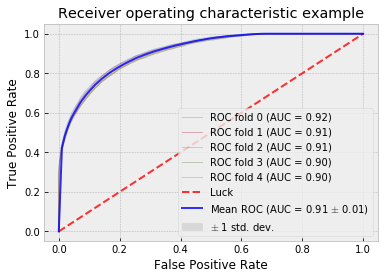

the ks value is : 0.6359971446604776
the roc curve is:


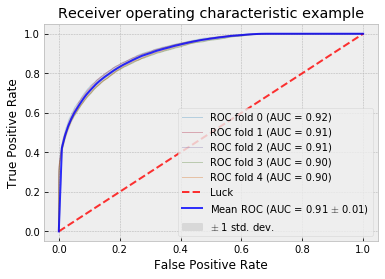

the ks value is : 0.6347959243156811
the roc curve is:


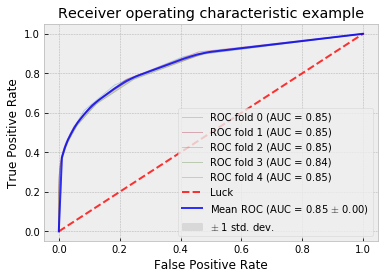

the ks value is : 0.9897715706299469
the roc curve is:


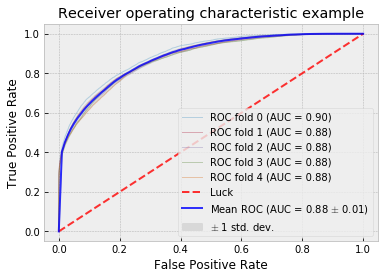

the ks value is : 0.5955668636979964


In [27]:
clf_lr_default = LogisticRegression()
clf_lr_best = LogisticRegression(C=0.01,class_weight={0:1,1:1},penalty='l2')
clf_rf_default = RandomForestClassifier()
clf_rf_best = RandomForestClassifier(criterion='gini',class_weight={0:1,1:1},max_depth=6,n_estimators=20)

plt.figure(figsize=(6,4))
lp.lr_train(X,y,clf_lr_default)
plt.figure(figsize=(6,4))
lp.lr_train(X,y,clf_lr_best)

plt.figure(figsize=(6,4))
lp.lr_train(X,y,clf_rf_default)

plt.figure(figsize=(6,4))
lp.lr_train(X,y,clf_rf_best)

In [43]:
# the final result is 
clf = LogisticRegression(C=0.01,class_weight={0:1,1:1},penalty='l2')
clf.fit(X,y)
coef = clf.coef_
print('the coefs of features are:')
pd.DataFrame(coef[0],index=multi_analysis_vars_1)

the coefs of features are:


,0
bc_open_to_buy_Merge_Bin_Bin_WOE,-1.030246
emp_title_Bin_Bin_WOE,-0.958251
int_rate_Merge_Bin_Bin_WOE,-0.564999
acc_open_past_24mths_Merge_Bin_Bin_WOE,-0.440555
total_bc_limit_Bin_WOE,0.651023
tot_hi_cred_lim_Bin_WOE,-0.143073
bc_util_Merge_Bin_Bin_WOE,-0.493194
dti_Bin_WOE,-0.365618
mo_sin_rcnt_tl_Merge_Bin_Bin_WOE,-0.188808
annual_inc_Bin_WOE,0.381110
